## K-Nearest Neighbors with RGB Reshaping and No Scaling

In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split

import pickle
import time

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
## function to read in the batch files
def unpickle(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin') # encoding latin otherwise no worky
    fo.close()
    return(dict)

In [4]:
def zero_center_pixels(data):
    scale = StandardScaler().fit(data)
    old_mean = scale.mean_.astype('float32')
    old_sigma = np.sqrt(scale.var_).astype('float32')
    return((data - old_mean) * 0.5 / old_sigma)

In [5]:
## read in the data
## manually is easy
data_batch_1 = unpickle('cifar-10-batches-py/data_batch_1')
data_batch_2 = unpickle('cifar-10-batches-py/data_batch_2')
data_batch_3 = unpickle('cifar-10-batches-py/data_batch_3')
data_batch_4 = unpickle('cifar-10-batches-py/data_batch_4')
data_batch_5 = unpickle('cifar-10-batches-py/data_batch_5')
test_batch = unpickle('cifar-10-batches-py/test_batch')
label_map = unpickle('cifar-10-batches-py/batches.meta')

In [6]:
## stack up the data batches
all_data = []

for i in data_batch_1['data']:
    all_data.append(i)
    
for i in data_batch_2['data']:
    all_data.append(i)

for i in data_batch_3['data']:
    all_data.append(i)

for i in data_batch_4['data']:
    all_data.append(i)
    
for i in data_batch_5['data']:
    all_data.append(i)

all_data = np.array(all_data)
print(all_data.shape)

(50000, 3072)


In [7]:
## stack up the label data
all_labels = data_batch_1['labels'] + data_batch_2['labels'] + data_batch_3['labels'] + data_batch_4['labels'] + data_batch_5['labels']
all_labels = np.array(all_labels)
print(all_labels.shape)

(50000,)


In [8]:
all_data_rgb = all_data.reshape(50000, 3, 32, 32).transpose(0,2,3,1).astype('float32')

In [9]:
all_data_rgb_flattened = np.array([i.flatten() for i in all_data_rgb])
all_data_rgb_flattened.shape

(50000, 3072)

In [10]:
test_data_rgb = test_batch['data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype('float32')
test_data_rgb_flattened = np.array([i.flatten() for i in test_data_rgb])
test_data_rgb_flattened.shape

(10000, 3072)

In [10]:
## trying KNN with reshaped pixels, no scaling

t0 = time.time()
knn = KNeighborsClassifier()
knn_fit = knn.fit(all_data_rgb_flattened, all_labels)
print('Train Wall time: ', time.time() - t0)

t1 = time.time()
knn_preds = knn_fit.predict(test_data_rgb_flattened)
print('Predict Wall time: ', time.time() - t1)

print('KNN Accuracy Score: ', accuracy_score(test_batch['labels'], knn_preds))

Train Wall time:  23.68236517906189
Predict Wall time:  2542.021425008774
KNN Accuracy Score:  0.3398


## Testing on Rotated Data

In [11]:
## figure out which approach to use for rotated testing
## pick the best performing one from above

rotated_dataset = []
for i in test_data_rgb:
    rotated_i = np.rot90(i)
    rotated_dataset.append(rotated_i)
rotated_dataset = np.array(rotated_dataset)

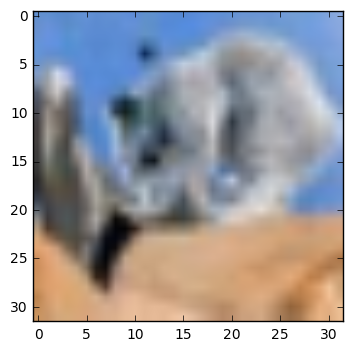

In [12]:
plt.imshow(test_data_rgb[0])
plt.show()

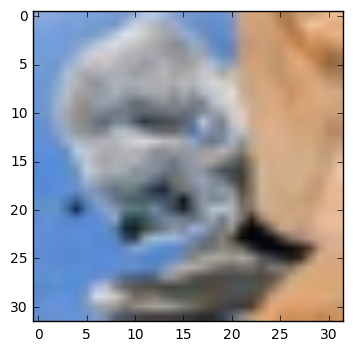

In [13]:
plt.imshow(rotated_dataset[0])
plt.show()

In [14]:
rotated_data_rgb_flattened = np.array([i.flatten() for i in rotated_dataset])

In [22]:
## trying KNN with reshaped pixels, no scaling

t0 = time.time()
knn = KNeighborsClassifier()
knn_fit = knn.fit(all_data_rgb_flattened, all_labels)
print('Train Wall time: ', time.time() - t0)

t1 = time.time()
knn_preds = knn_fit.predict(rotated_data_rgb_flattened)
print('Predict Wall time: ', time.time() - t1)

print('KNN Accuracy Score: ', accuracy_score(test_batch['labels'], knn_preds))

Train Wall time:  117.61799001693726
Predict Wall time:  12401.664968013763
KNN Accuracy Score:  0.172


## Training on Less, Stratified Data

In [15]:
y_strats = [np.argmax(y) for y in all_labels]
X_AB, _, y_AB, _ = train_test_split(
    all_data_rgb_flattened, all_labels, test_size=0.33334, random_state=0, stratify=y_strats)

y_AB_strats = [np.argmax(y) for y in y_AB]
X_A, _, y_A, _ = train_test_split(
    X_AB, y_AB, test_size=0.5, random_state=0, stratify=y_AB_strats)

print('X shape: ', X_AB.shape)
print('Y shape: ', y_AB.shape)

X shape:  (33333, 3072)
Y shape:  (33333,)


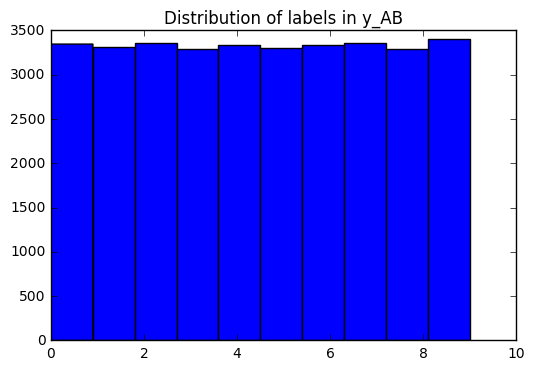

In [16]:
## histogram of labels
plt.hist(y_AB)
plt.title('Distribution of labels in y_AB')
plt.show()

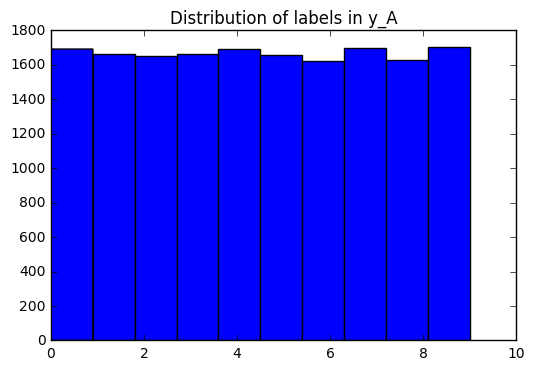

In [18]:
## histogram of labels
plt.hist(y_A)
plt.title('Distribution of labels in y_A')
plt.show()

In [19]:
## re-running on X_AB, y_AB

t0 = time.time()
knn = KNeighborsClassifier()
knn_fit = knn.fit(X_AB, y_AB)
print('Train Wall time: ', time.time() - t0)

t1 = time.time()
knn_preds = knn_fit.predict(test_data_rgb_flattened)
print('Predict Wall time: ', time.time() - t1)

print('KNN Accuracy Score: ', accuracy_score(test_batch['labels'], knn_preds))

Train Wall time:  12.699263095855713
Predict Wall time:  2669.6473178863525
KNN Accuracy Score:  0.3286


In [20]:
## re-running on X_A, y_A

t0 = time.time()
knn = KNeighborsClassifier()
knn_fit = knn.fit(X_A, y_A)
print('Train Wall time: ', time.time() - t0)

t1 = time.time()
knn_preds = knn_fit.predict(test_data_rgb_flattened)
print('Predict Wall time: ', time.time() - t1)

print('KNN Accuracy Score: ', accuracy_score(test_batch['labels'], knn_preds))

Train Wall time:  8.763077974319458
Predict Wall time:  1635.2032089233398
KNN Accuracy Score:  0.3139
